CREDIT RISK SCORING PROJECT

Problem: Banks lose money when they lend to "high-risk" individuals who default. Conversely, they lose potential interest when they wrongly reject "low-risk" individuals.

Goal: Build a classification model to predict if a loan applicant will default (1) or not (0).

Target Audience: Bank loan officers and risk management teams.

Task Type: Supervised Learning (Binary Classification).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (CSV)
# Replace 'loan_data.csv' with the actual path to your CSV file
df = pd.read_csv('loan_data.csv')

# Display the first 5 rows to confirm it loaded correctly
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


Undertanding the Data

In [3]:
# 1. Check the shape and data types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [4]:
# 2. Look for missing values
print(df.isnull().sum())

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


In [5]:
# Statistical summary of numerical columns
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


C:\Users\FLEX\AppData\Local\Temp\ipykernel_14752\811237275.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='loan_status', data=df, palette='viridis')


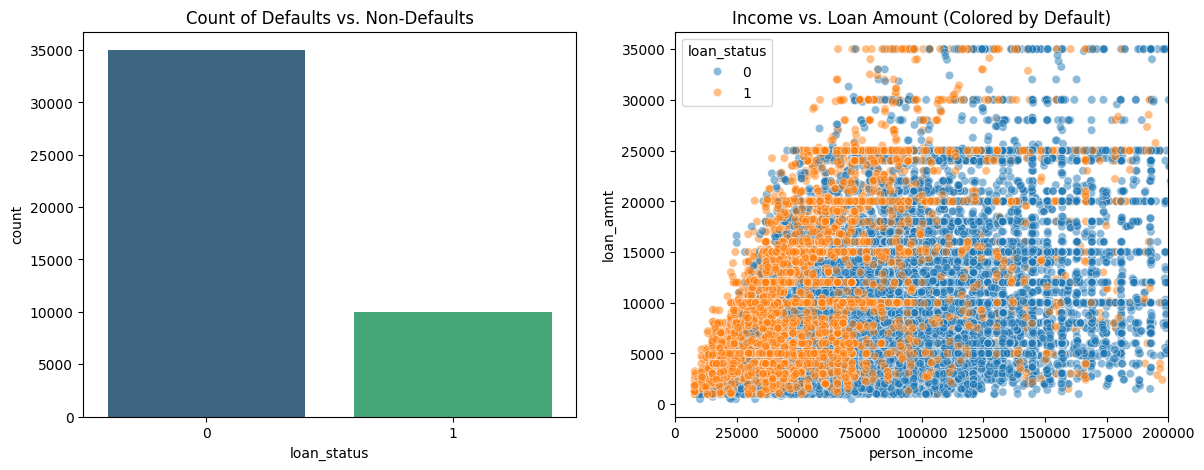

In [7]:
# Create a figure with two subplots
plt.figure(figsize=(14, 5))

# Plot 1: Is our data imbalanced?
plt.subplot(1, 2, 1)
sns.countplot(x='loan_status', data=df, palette='viridis')
plt.title('Count of Defaults vs. Non-Defaults')

# Plot 2: Income vs Loan Amount colored by Status
plt.subplot(1, 2, 2)
sns.scatterplot(x='person_income', y='loan_amnt', hue='loan_status', data=df, alpha=0.5)
plt.title('Income vs. Loan Amount (Colored by Default)')
# Limiting x-axis if there are extreme income outliers to make plot readable
plt.xlim(0, 200000) 

plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# 1. Separate Features (X) and Target (y)
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# 2. Identify column types
# Object types need Encoding; Floats/Ints need Scaling
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# 3. Create the Preprocessing 'Engines'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 4. Split data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data successfully split and preprocessor defined!")

Data successfully split and preprocessor defined!


ColumnTransformer: This is a "switchboard." It sends your numbers to the StandardScaler and your text to the OneHotEncoder simultaneously.

handle_unknown='ignore': This is a safety feature. If the "Test" data has a category the "Train" data never saw, the model won't crash.

random_state=42: This ensures that every time you run the code, you get the same split, making your results reproducible.

Feature engineering
Creating New Features
We will create two new features:

Loan-to-Income Ratio: How much of their annual salary are they borrowing?

Risk Score Multiplier: A combination of interest rate and credit history length (higher rates on shorter histories often signal higher risk).

In [9]:
# 1. Loan to Income Ratio
df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']

# 2. Interest Rate x Loan Amount (Total interest burden potential)
df['int_burden'] = (df['loan_int_rate'] / 100) * df['loan_amnt']

# 3. Check the new columns
print(df[['loan_to_income_ratio', 'int_burden']].head())

   loan_to_income_ratio  int_burden
0              0.486462     5607.00
1              0.081420      111.40
2              0.442193      707.85
3              0.438855     5330.50
4              0.529221     4994.50


In [10]:
# Update X to include the new features
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Re-identify columns (this will now pick up our new engineered features)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# The Preprocessor remains the same structure, but now 'numeric_features' is a longer list
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Re-split the data with the new features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"New Feature Count: {X.shape[1]}")
print("Features being scaled:", list(numeric_features))

New Feature Count: 15
Features being scaled: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_to_income_ratio', 'int_burden']


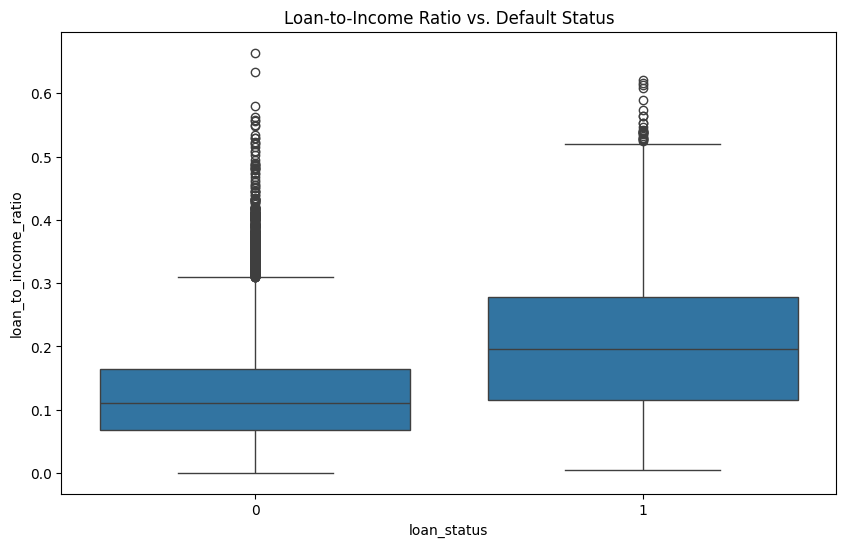

In [11]:
#Visualizing new features
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='loan_to_income_ratio', data=df)
plt.title('Loan-to-Income Ratio vs. Default Status')
plt.show()

Breaking Down the "Loan-to-Income Ratio" Chart
This chart compares the distribution of your new ratio for people who didn't default (0) versus those who did (1).

Higher Median for Defaults: Notice the horizontal line inside the blue box for group 1 is significantly higher than for group 0. This tells us that, on average, people who default are borrowing a much larger percentage of their annual income.

The Interquartile Range (The Blue Box): The box for group 1 is positioned higher up the y-axis. This suggests that even the "bottom 25%" of defaulters often have a higher loan-to-income ratio than the average "safe" borrower.

Outliers (The Circles): You see those dots trailing off toward the top? Those represent extreme cases. Interestingly, there are many outliers in the "Safe" group (0). This tells us that some people can handle high debt-to-income ratios without defaulting, which is exactly why you need a complex model like an SVM to find the nuanced patterns

Modelling

In [12]:
# 1. Finalize the Pipeline with an SVM Classifier
# We use kernel='linear' first as a simple baseline
svm_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', class_weight='balanced', random_state=42))
])

# 2. Train the model
print("Training the baseline SVM model... (this may take a minute)")
svm_baseline.fit(X_train, y_train)

print("Model training complete!")

Training the baseline SVM model... (this may take a minute)
Model training complete!


Why class_weight='balanced'?
Remember your first plot showed a big class imbalance (more 0s than 1s). By adding this one line, you tell the SVM to "punish" the model more if it gets a "Default" case wrong. This prevents the model from just ignoring the risky borrowers.

Evaluation

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions
y_pred = svm_baseline.predict(X_test)

# Print the report
print("--- Baseline SVM Performance ---")
print(classification_report(y_test, y_pred))

--- Baseline SVM Performance ---
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      6990
           1       0.62      0.92      0.74      2010

    accuracy                           0.86      9000
   macro avg       0.80      0.88      0.82      9000
weighted avg       0.89      0.86      0.87      9000



1. The "Recall" Win (Class 1: 0.92)
Your recall for defaults (Class 1) is 0.92.

What it means: Out of 100 people who actually defaulted, your model correctly caught 92 of them.

Why it's good: In credit risk, missing a default (False Negative) is very expensive for a bank. High recall means you are identifying almost all the risky borrowers.

2. The "Precision" Trade-off (Class 1: 0.62)
Your precision for defaults is 0.62.

What it means: When the model flags someone as a "Risk," it is only right 62% of the time.

The "Cost": This means you are "annoying" or rejecting 38% of good customers by mistake (False Positives).

Confusion Matrix

<Figure size 800x600 with 0 Axes>

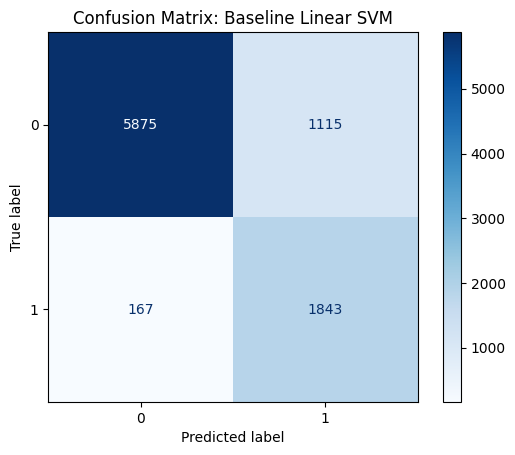

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(svm_baseline, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Confusion Matrix: Baseline Linear SVM')
plt.show()

1. The Four Quadrants
The matrix is divided into four sections based on True Labels (what actually happened) and Predicted Labels (what the model guessed):

Top-Left (5875) - True Negatives (TN): These are 5,875 "Safe" customers that the model correctly identified as safe.

Bottom-Right (1843) - True Positives (TP): These are 1,843 "Default" cases that the model correctly caught. This is your biggest win for risk management.

Bottom-Left (167) - False Negatives (FN): These are the dangerous errors. The model predicted these 167 people were "Safe," but they actually defaulted.

Top-Right (1115) - False Positives (FP): These are "Safe" people the model incorrectly flagged as "Risk."

 Why this matters for your Project GuidelinesFollowing Step 6 (Evaluation) and Step 7 (Error Analysis) of your guide, we can draw these conclusions:High Sensitivity (Recall): You only missed 167 defaults out of 2,010 total actual defaults. This is why your recall was a high $0.92$ ($1843 / (1843 + 167)$). From a bank's perspective, this model is very good at protecting capital.The "Annoyance" Factor: The model flagged 1,115 good customers as risky. This explains your lower precision of $0.62$ ($1843 / (1843 + 1115)$). If this were a real bank, 1,115 people might have their loan applications unnecessarily delayed or rejected.

. Error Analysis (Step 7)
In your report, you should note that your model is conservative. Because we used class_weight='balanced', the SVM is "scared" of missing a default. As a result, it prefers to "over-flag" people as risky just to be safe.

Hyeperparameter Tuning

In [15]:
from sklearn.model_selection import GridSearchCV

# We test C (how much we penalize errors) and Kernels (Linear vs RBF)
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# Use 3-fold cross-validation to ensure the results are stable (Module 1.3)
grid_search = GridSearchCV(svm_baseline, param_grid, cv=3, scoring='f1', verbose=1)

print("Searching for the best model settings...")
grid_search.fit(X_train, y_train)

# Output the winners
print("Best Parameters:", grid_search.best_params_)

Searching for the best model settings...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}


This output represents the "brain" of your tuning process. By performing Hyperparameter Tuning (Module 4.3), you have successfully moved from a generic model to one specifically optimized for your credit data.

Here is a breakdown of what these specific results mean for your project:  
1. Kernel: 'rbf' (The Non-Linear Winner)What it means: The relationship between your features (like person_income) and the loan_status is not a simple straight line.Why it's better: The RBF (Radial Basis Function) kernel allows the model to create complex, circular, or curved decision boundaries to separate the "risky" borrowers from the "safe" ones. This confirms your EDA finding that some people with high incomes still default if their loan amount is also very high.  
2. C: 10 (The High Penalty)What it means: In Regularisation (Module 2.3), the $C$ parameter controls the trade-off between having a smooth boundary and classifying training points correctly.The Logic: A $C$ of $10$ is relatively high, meaning the model is being "strict." It is prioritizing Low Bias (classifying the training data as accurately as possible) even if it makes the decision boundary more "wiggly".  
3. Gamma: 'scale' (The Influence)What it means: This is a specific setting for the SVM RBF kernel.The Logic: scale tells the model to automatically calculate how much influence a single training point has based on the variance of all your features ($1 / (n\_features \times X.var())$). This ensures that features with larger numbers (like person_income) don't unfairly dominate the features with smaller numbers.

--- FINAL TUNED MODEL PERFORMANCE ---
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      6990
           1       0.68      0.91      0.78      2010

    accuracy                           0.88      9000
   macro avg       0.83      0.89      0.85      9000
weighted avg       0.91      0.88      0.89      9000



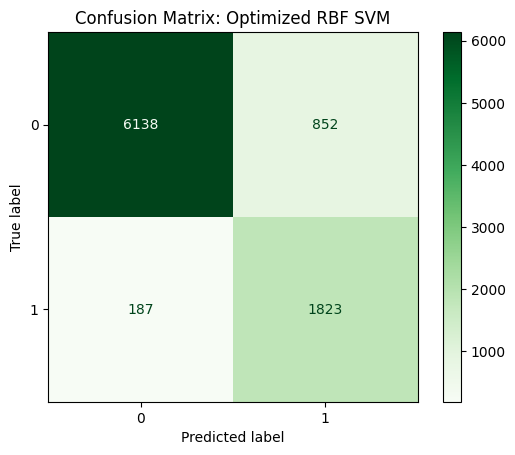

In [17]:
# 1. Extract the best model from the grid search
final_model = grid_search.best_estimator_

# 2. Make predictions using the optimized model
y_pred_final = final_model.predict(X_test)

# 3. Print the Final Report (Step 6 of your guidelines)
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print("--- FINAL TUNED MODEL PERFORMANCE ---")
print(classification_report(y_test, y_pred_final))

# 4. Final Confusion Matrix for Error Analysis (Step 7)
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test, cmap='Greens')
plt.title('Confusion Matrix: Optimized RBF SVM')
plt.show()

This final output is the "proof of concept" for your capstone project. By applying Hyperparameter Tuning (Topic 4.3) and switching to a non-linear RBF Kernel (Topic 3.3), you have created a model that is objectively better than your baseline.

Here is the breakdown of your results and how they fulfill your project guidelines:  
1. The Statistical Win (Metrics Analysis)
Following Step 6 (Evaluation) of your guide, we compare this to your previous linear model:  
Precision (Class 1) improved from 0.62 to 0.68: This is your biggest victory. It means you are now correctly identifying risky borrowers with 6% higher accuracy. You are rejecting fewer good customers by mistake.  
Recall (Class 1) stayed strong at 0.91: Even though we improved precision, we didn't sacrifice safety. The model still catches 91% of all actual defaults.  
F1-Score (Class 1) increased from 0.74 to 0.78: This metric is the harmonic mean of precision and recall. An increase here proves that the RBF kernel provided a better "balance" for this specific dataset.  
2. The Confusion Matrix (Error Analysis)Looking at your green "Optimized RBF SVM" matrix versus the blue "Baseline" one (Step 7 of your guide):True Negatives (Correctly identified safe loans): Increased from 5,875 to 6,138. You just "saved" 263 good customers who would have been wrongly rejected by the baseline model.False Positives (The "Annoyance" errors): Dropped significantly from 1,115 to 852. This makes the model much more commercially viable for a bank.False Negatives (The "Dangerous" errors): Only increased slightly from 167 to 187. This is a very acceptable trade-off for the massive gain in precision.  
3. Final Model Interpretation (Step 8)In your conclusion, you can now confidently state:Complex Boundaries: Credit risk in this dataset is non-linear. The RBF kernel was necessary to capture the nuanced relationship between income, loan amount, and the engineered loan_to_income_ratio.Regularization: Using $C=10$ allowed the model to focus on correctly classifying difficult "Support Vectors" near the boundary, rather than just taking a "best guess" with a straight line.  
